# pulse2percept: Edema Example




In [1]:
import skimage.io as skio

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pulse2percept as p2p

/home/ezgi/anaconda3/lib/python3.6/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2019-02-20 13:54:37,459 [pulse2percept] [INFO] Welcome to pulse2percept


In [3]:
# Load an Argus II array
argus = p2p.implants.ArgusII(x_center=-800, y_center=-400, h=0, rot=np.deg2rad(-35), eye='RE')

2019-02-20 13:54:43,802 [pulse2percept.implants] [WARNING] Distance to fovea=3490 > 3000 um, assuming same layer thicknesses as for 1550-3000 um distance.
2019-02-20 13:54:43,804 [pulse2percept.implants] [WARNING] Distance to fovea=3087 > 3000 um, assuming same layer thicknesses as for 1550-3000 um distance.
2019-02-20 13:54:43,805 [pulse2percept.implants] [WARNING] Distance to fovea=3202 > 3000 um, assuming same layer thicknesses as for 1550-3000 um distance.


In [4]:
# Start the simulation framework
sim = p2p.Simulation(argus, engine='joblib', n_jobs=1)

In [9]:
#Set up an edema_map
s_sample = 100
xhi = 1000
xlo = -1000
yhi = 1000
ylo = -1000
sampling=s_sample
num_x = int((xhi - xlo) / sampling + 1)
num_y = int((yhi - ylo) / sampling + 1)
gridx, gridy = np.meshgrid(np.linspace(xlo, xhi, num_x),
                                             np.linspace(ylo, yhi, num_y),
                                             indexing='xy')
edema_map = np.zeros((gridx.shape[0], gridx.shape[1],2, len(argus.electrodes)), dtype=float)


In [5]:
# Set parameters of the optic fiber layer (OFL)
# In previous versions of the model, this used to be called the `Retina`
# object, which created a spatial grid and generated the axtron streak map.

# Set the spatial sampling step (microns) of the retinal grid
sim.set_optic_fiber_layer(sampling=s_sample, n_axons=501, n_rho=801, rho_range=(4, 45),
                          sensitivity_rule='decay', decay_const=5.0,
                          contribution_rule='max', edema.)

2019-01-30 13:13:19,974 [pulse2percept.retina] [INFO] Loading file "./retina_RE_s100_a501_r801_5000x6500.npz".


In [6]:
# Set parameters of the ganglion cell layer (GCL)
# In previous versions of the model, this used to be called `TemporalModel`.

# Set the temporal sampling step (seconds)
t_sample = 0.01 / 1000
sim.set_ganglion_cell_layer('Nanduri2012', tsample=t_sample)

### 1.4 Specifying the input stimulus

In [7]:
# Send a pulse train to two specific electrodes, set all others to zero
stim = {
    'C1': p2p.stimuli.PulseTrain(t_sample, freq=50, amp=20, dur=0.5), 
}

We can visualize the specified electrode array and its location on the retina with respect to the optic disc:

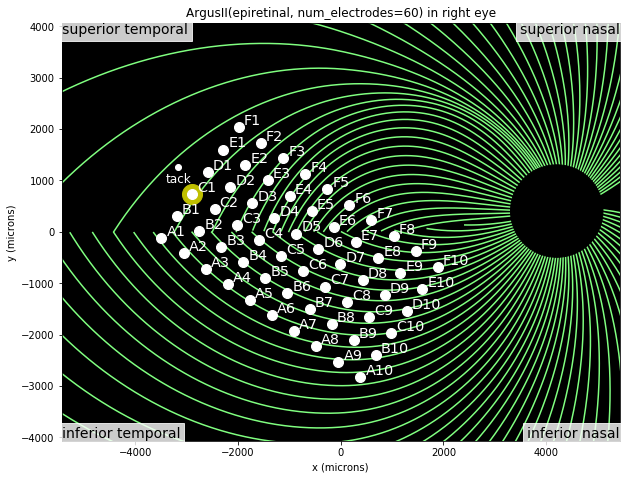

In [8]:
p2p.viz.plot_fundus(argus, stim, upside_down=False);

# 2. Running the Simulation

Simulations are run by passing an input stimulus `stim` to `p2p.pulse2percept`. Output is a `p2p.utils.TimeSeries` objects that contains the brightness changes over time for each pixel.

In [9]:
# Run a simulation
# - tol: ignore pixels whose efficient current is smaller than 10% of the max
# - layers: simulate ganglion cell layer (GCL) and optic fiber layer (OFL),
#   but ignore inner nuclear layer (INL) for now
percept = sim.pulse2percept(stim, tol=0.1, layers=['GCL', 'OFL'])

2019-01-30 13:13:20,929 [pulse2percept.api] [INFO] Starting pulse2percept...
2019-01-30 13:13:28,424 [pulse2percept.api] [INFO] tol=10.0%, 2824/3366 px selected
2019-01-30 13:14:22,703 [pulse2percept.api] [INFO] Done.


# 3. Analyzing Output

You can look at the brightness time course of every pixel, or you can simply plot the brightest frame in the whole brightness "movie":

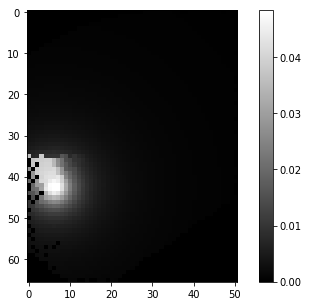

In [10]:
frame = p2p.get_brightest_frame(percept)
plt.figure(figsize=(8, 5))
plt.imshow(frame.data, cmap='gray')
plt.colorbar()

Finally, you can also dump the percept to file, by creating MP4 or MOV videos (requires Scikit-Video).